# Gaussian Hidden Markov Models

In [1]:
# Set your working directory
import os
cwd = os.getcwd()
os.chdir(cwd[:cwd.find("stat_bay") + len("stat_bay")])

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from models.HMM import HMM
from models.posteriors import wishart,norm, dirichlet, simul_s, _Phi,order, apply_by_group
from models.simulation import simul_gauss

## We will fit a gaussian HMM on the popular iris dataset
This example demonstrate that the standard mixtures are included in HMM models

A  gaussian HMM is made of :
* A posterior `normal-inverse_wishart` distribution over $\theta = (\mu,\Sigma) \in IR^{2xd}xIR^{2xdxd}$; where $d$ = dim of the gaussian vectors
* A posterior distribution over $S \in IR^n$, the states vector; where $n = #obs$
* A posterior `dirichlet` distribution over the transition matrix $P \in IR^{2x2}$

We start by defining the posterior of $\theta = \left(\mu,\Sigma\right)$

In [4]:
tDictDist = {"mu": norm(), "omega_inv": wishart()} # Note that, \0mega^{-1} is simulated instead \Omega

#Let set the default parameters

d = 4 # dim of our gaussian vectors
k = 3 # Number of components
nu = np.array([10]*k) # Degree of freedoms of the prior of \Omega
omega_inv = np.array([np.eye(d)]*k)/10 # Cov matrix of the prior of \Omgea

mu =  np.array([np.zeros(d)]*k) # Mean of the prior over  \mu
sigma = 10*np.array([np.eye(d)]*k) # Cov matrix of the prior over \mu

tDictDist["mu"]._set_default( mu0 = mu, sigma0_inv = np.linalg.inv(sigma))
tDictDist["omega_inv"]._set_default(nu0 = nu, omega0_inv = omega_inv)

In [5]:
sDist = simul_s(func = _Phi) # S distribution

Now the $P$ distribution

In [6]:
pDist = dirichlet() # A dirichlet distribution is common for probability vectors
pDist._set_default(a = 50*np.ones((k,k))/k)

# The gaussian mixture on iris dataset

Let's simulate an artificial gaussian mixture

In [7]:
# Load the iris dataset
from sklearn import datasets
iris = datasets.load_iris()
iris.data.shape

(150, 4)

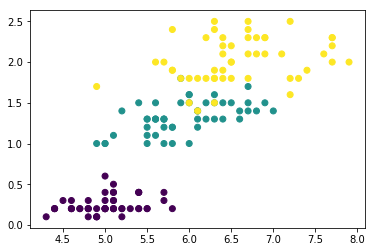

In [8]:
plt.scatter(iris.data[:, 0], iris.data[:, 3], c = iris.target)  # Our clusters

Now, we're gonna define the gHMM

In [9]:
shuffle = np.arange(len(iris.data))
np.random.shuffle(shuffle)

target = iris.target[:][shuffle]
target2 = pd.Categorical(target).codes

In [10]:
Y = iris.data[:][shuffle] # Obs
S = np.random.choice(k, len(Y)) # Initial states
P = np.ones((k,k))/k # Initial transition matrix
mu =  np.array([ np.zeros(d)]*k) # Initial 'mean'
omega_inv =  np.array([np.eye(d)]*k)/10 # Initial cov matrix, any !
Theta = {"mu": mu , "omega_inv": omega_inv } # Initial parameters sample

In [11]:
ghmm = HMM(tDictDist, sDist, pDist, Y=Y, S = S , Theta = Theta, P = P )

In [12]:
ghmm.run(500) # Start the gibbs sampler n-times

C:\Users\kneroma\OneDrive - TF1\Documents\pppp\ENSAE\stat_bay\models\posteriors.py:83: RuntimeWarning: invalid value encountered in true_divide
  r = np.argsort(u/v)


# Can we recover the true clusters ? Let's see !

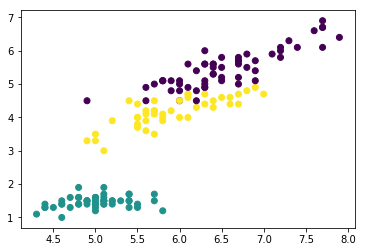

In [13]:
plt.scatter(Y[:, 0], Y[:,2], c = ghmm.H["S"][-5])

In [14]:
# Instead for taking just the last sample as prediction, we can compute the 
# mode of predicted states for each data point
Sgmm = np.array(ghmm.H["S"][-50:]) # We just consider latest steps in our simulation
Sgmm = np.apply_along_axis(np.bincount, 0, Sgmm, minlength = k )
Sgmm = Sgmm.argmax(0)
Sgmm[:10]

array([1, 0, 1, 1, 2, 2, 2, 0, 0, 0], dtype=int64)

In [15]:
pd.crosstab(target2, Sgmm)

col_0,0,1,2
row_0,,,
0,0,50,0
1,5,0,45
2,50,0,0


In [16]:
ghmm.tDictDist["mu"].rvs() # We can sample mu & omega distribution

array([[6.56029538, 2.97605426, 5.50002942, 1.94931232],
       [4.93882136, 3.41602903, 1.4558197 , 0.23099995],
       [5.94318964, 2.74792831, 4.16772898, 1.25717512]])

In [17]:
np.array([history["mu"] for history in ghmm.H["Theta"][-50::]]).mean(0) # Mean predicted value for mu

array([[6.53806091, 2.94255064, 5.48322404, 1.99491606],
       [5.00546732, 3.40848687, 1.46754778, 0.24222247],
       [5.94888293, 2.78393631, 4.24663616, 1.31134142]])

In [18]:
np.array(ghmm.H["P"][-50::]).mean(0) # Mean transition matrix

array([[0.3612787 , 0.33890879, 0.29981252],
       [0.31187417, 0.32298671, 0.36513912],
       [0.33456107, 0.32999054, 0.33544839]])

###  Comparison with Kmeans

In [19]:
from sklearn.cluster import KMeans

In [20]:
km = KMeans(n_clusters= k, n_init= 50)

In [21]:
km.fit(Y)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=50, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

#### As we can see it, our model performs better than Kmeans : 5 vs 16 misclassified observations

In [22]:
pd.crosstab(target2, km.labels_)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,48,2
2,0,14,36
